
Incorporating fake CoT prompt P3. This experiment aims to test whether GPT-3.5 has the ability to automatically reflect and optimize its translations.

P3: Translation Request- Sentence-by-Sentence Translation. Language Pair: SRC to TGT. 
Instructions: 
1. Each sentence of the document will be provided individually in the "Original Sentence" section. 
2. In the "Translation" section, please provide the corresponding translation for each sentence, considering the context and aiming for faithful translation while minimizing unaligned translations. 
3. Avoid including any explanations in the translation. 
4. Please review the translations for verifying that they remain faithful to the original text and provide revised versions accordingly if necessary. If no revisions are needed, provide the translations as they are.

In [7]:

from openai import OpenAI
import pandas as pd
client = OpenAI()

df = pd.read_csv('verbs.csv')

def translate_verb(arb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": 
             "You are an expert in Moroccan Darija dialect and in translating Darija to English." +
             "Purpose of the translation: To study the accuracy of LLMs on Darija," +
             "making sure that the language accounts for particular nuances of the language such as emphasis and articulation."+
             "Target audience: Darija Computational linguists"+
             "Instructions: 1. Please provide the corresponding translation for the word, aiming for faithful translation while minimizing unaligned translations."+
             "2. Avoid including any explanations in the translation."+
             "3. Please review the translations for verifying that they remain faithful to the original text and provide revised versions accordingly if necessary. If no revisions are needed, provide the translations as they are."
            },
            {"role": "user", "content": 
             "Translate the provided Moroccan Darija dialect verb into English using word-by-word translation."
#             "You must account for concepts such as articulation and emphasis in Darija and unique verbs to the language." + 
#             "The output must not be an infinitive verb. No explanations are needed in the output"
             },
            {"role": "assistant", "content": "OK, I understand. I am ready for the verb translation."},

            {"role": "user", "content": f"{arb}"},            
            ], 
        temperature=0.1  # Deterministic responses
        )
    return completion.choices[0].message.content
df['transl'] = df['darija_ar'].apply(translate_verb)

# Display or save the resulting DataFrame
print(df['transl'])

0                       No.
1                     drink
2                   Entered
3                      Went
4                understand
               ...         
1027                  Reach
1028    طفا - He turned off
1029                   Wind
1030             غش - Cheat
1031                   Peel
Name: transl, Length: 1032, dtype: object


[('No.', 'eat', 0, False), ('drink', 'drink', 1.0, True), ('Entered', 'enter', 1.0, True), ('Went', 'go_out', 0.5, True), ('understand', 'understand', 1.0, True), ('Explanation', 'explain', 0, False), ('Read', 'learn', 1.0, True), ('read', 'teach', 0.25, False), ('hear', 'hear', 1.0, True), ('saw', 'see', 1.0, True), ('smell', 'smell', 1.0, True), ('He_knocked', 'taste', 0, False), ('قاس_-_measured', 'touch', 0, False), ('walked', 'go', 0.5, True), ('came', 'come', 1.0, True), ('Went_out', 'ascend', 0, False), ('go_down', 'go_down', 1.0, True), ('عام_-_Year', 'swim', 0, False), ('غرق_-_Drown', 'drown', 0, False), ('wore', 'wear', 1.0, True), ('I_asked', 'take_off', 0, False), ('buy', 'buy', 1.0, True), ('sold', 'sell', 1.0, True), ('He/she/it_responded', 'bargain', 0, False), ('wrote', 'write', 1.0, True), ('Rub', 'clean', 0.2, False), ('hit', 'hit', 1.0, True), ('You_(singular)_surrender.', 'salute', 0, False), ('He_went', 'fatigue', 0, False), ('tskhskh', 'exhaust', 0, False), ('Laug

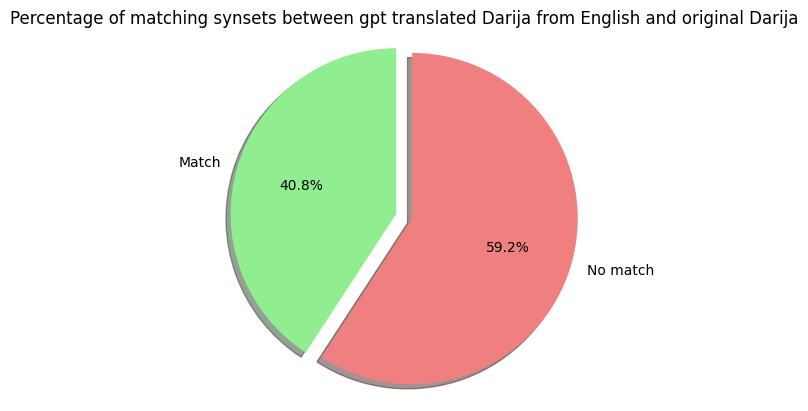

In [8]:
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn

eng = df['eng']
transl = df['transl']

transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score
# Calculate and print the path similarity for each pair of verbs with similar index

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
print(results)


# Extract the last element of each tuple in the list (representing True or False values)
last_elements = [result for *_, result in results]

# Count how many comparisons are True
true_count = sum(last_elements)  # True evaluates to 1, so summing directly counts the True values

# Calculate the percentage of True vs False
total_comparisons = len(results)
false_count = total_comparisons - true_count

# Plot pie chart
labels = 'Match', 'No match'
sizes = [true_count, false_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentage of matching synsets between gpt translated Darija from English and original Darija")
plt.show()
